# Gamma-Quant

Some short explanations of the method presented in this paper:

γ-Quant: Towards Learnable Quantization for Low-bit Pattern Recognition, Mishal Fatima, Shashank Agnihotri, Marius Bock, Kanchana Vaishnavi Gandikota, Kristof Van Laerhoven, Michael Moeller, and Margret Keuper, In DAGM German Conference on Pattern Recognition, 2025. DOI: [
https://doi.org/10.48550/arXiv.2509.22448](https://ubi29.informatik.uni-siegen.de/usi/pdf/ubi_dagm25.pdf)

I used here an ECG timeseries signal as an illustration.

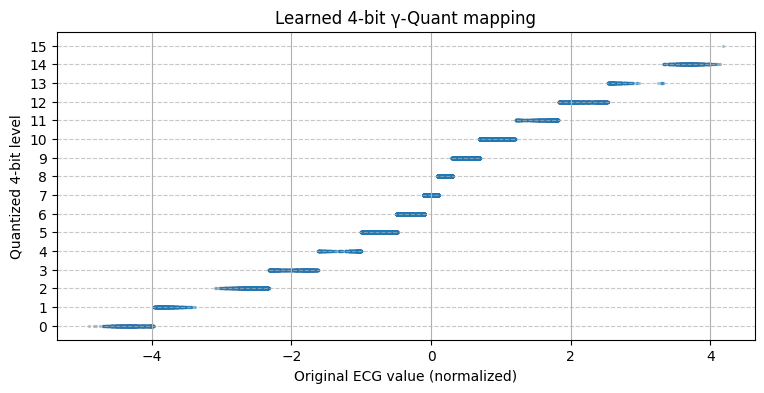

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# create a ECG-like waveform:
data = [ 0, 0, 0.01, -0.03, -0.01, -0.04, -0.04, -0.03, -0.05, -0.02,
          -0.04,  0, -0.03, -0.01, -0.04,  0.02, -0.06, -0.04, -0.01,
          -0.03, 0.01,  0.05,  0.05,  0.11, 0.18,  0.16,  0.25,  0.21,
          0.18,  0.09,  0.23,  0.06,  0.15,  0.08, -0.03,  0, -0.02,
          -0.09, -0.08, -0.04, -0.05,  0.01,  0.15,  0.16,  0.63,  0.77,
          1.15,  0.51, -0.13, -0.77, -1.41, -1.25, -0.87, -0.59, -0.32,
          -0.27, -0.24, -0.23, -0.19, -0.2, -0.18, -0.17, -0.17, -0.17,
          -0.16, -0.15, -0.15, -0.15, -0.21, -0.13, -0.17, -0.12, -0.13,
          -0.13, -0.1, -0.06, -0.08, -0.08, -0.04, -0.04,  0, 0, 0.06,
          0.06, 0.12, 0.11, 0.13, 0.21, 0.27, 0.23, 0.28, 0.2, 0.25, 0.15 ]
n = 900  # repeat this n times and add noise to simulate an ECG timeseries:
X = np.tile(data, n)+0.05*np.random.randn(len(data)*n)
t = list(range(len(X)))
X_norm = (X - np.mean(X)) / np.std(X)  # normalize all sensor values into X

# the γ-QUANT 4-bit quatizer
# Example, replace with model's learned γ, μ
gamma = 0.65     # typical range ~0.3–1.5
mu = 0.1         # offset / mean
# γ-Quant transform:
X_trans = np.sign(X_norm - mu) * np.abs(X_norm - mu)**gamma
N = 4  # Map to 4-bit uniform range [0..15]
X_min, X_max = X_trans.min(), X_trans.max()
X_scaled = (X_trans - X_min) / (X_max - X_min)
X_q = np.floor(X_scaled * (2**N - 1)).astype(int)

# visualize mapping curve
plt.figure(figsize=(9,4))
plt.scatter(X_norm, X_q, s=2, alpha=0.3)
plt.xlabel("Original ECG value (normalized)")
plt.ylabel("Quantized 4-bit level")
plt.title("Learned 4-bit γ-Quant mapping")
plt.yticks(range(0, 16))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

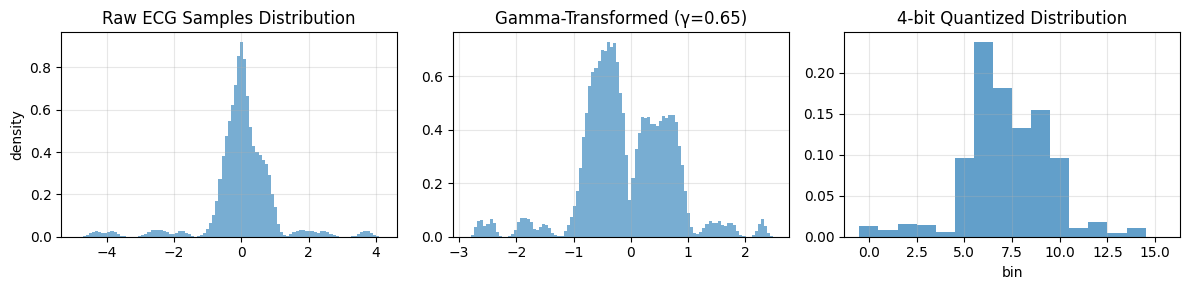

In [23]:
# visualize histogram of bins
fig, axs = plt.subplots(1, 3, figsize=(12,3), sharex=False)

# Raw ECG: Shows natural, Gaussian-ish ECG morphology with long tails at R-peaks
bins_input = np.linspace(X_norm.min(), X_norm.max(), 100)
axs[0].hist(X_norm, bins=bins_input, density=True, alpha=0.6, histtype="stepfilled")
axs[0].set_ylabel("density")
axs[0].set_title("Raw ECG Samples Distribution")
axs[0].grid(True, alpha=0.3)

# Gamma-transformed ECG: compression of large/small values expansion near zero,
# asymmetry if μ ≠ 0, shape bending based on γ
bins_gamma = np.linspace(X_trans.min(), X_trans.max(), 100)
axs[1].hist(X_trans, bins=bins_gamma, density=True, alpha=0.6, histtype="stepfilled")
axs[1].set_title(f"Gamma-Transformed (γ={gamma:.2f})")
axs[1].grid(True, alpha=0.3)

# Quantized 4-bit bins: Shows how transformed values are mapped into 16 bins
bins_quant = np.arange(-0.5, 16.5, 1)  # bins centered on integers 0–15
axs[2].hist(X_q, bins=bins_quant, density=True, alpha=0.7, histtype="stepfilled")
axs[2].set_xlabel("bin")
axs[2].set_title("4-bit Quantized Distribution")
axs[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

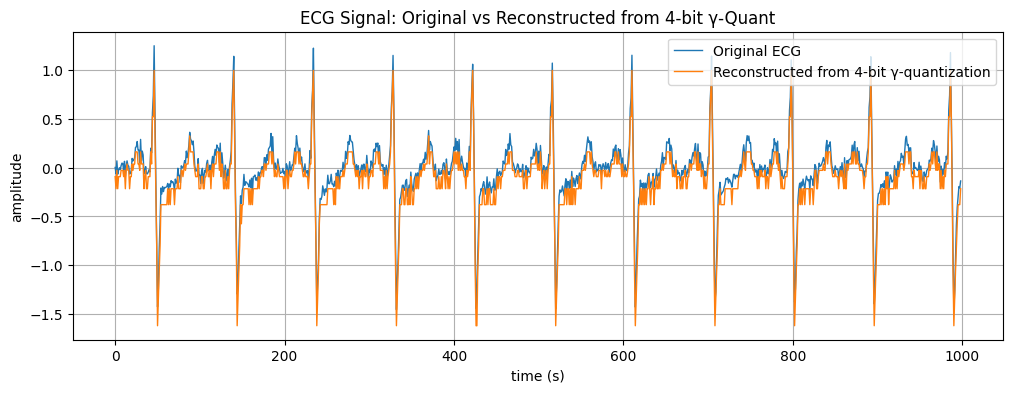

In [26]:
# visualization ECG waveform (raw vs quantized)
# convert back to "decompressed" waveform so we can plot it, uysing the inverse
# of the scaling step:
X_recon_norm = X_q / (2**N - 1) * (X_max - X_min) + X_min

# Undo the nonlinear γ transform (approximate inverse)
X_recon = np.sign(X_recon_norm) * np.abs(X_recon_norm)**(1/gamma)
X_recon = X_recon * np.std(X) + np.mean(X)  # de-normalize

plt.figure(figsize=(12,4))
plt.plot(t[:999], X[:999], label="Original ECG", linewidth=1)
plt.plot(t[:999], X_recon[:999], label="Reconstructed from 4-bit γ-quantization", linewidth=1)
plt.legend()
plt.title("ECG Signal: Original vs Reconstructed from 4-bit γ-Quant")
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.grid(True)
plt.show()

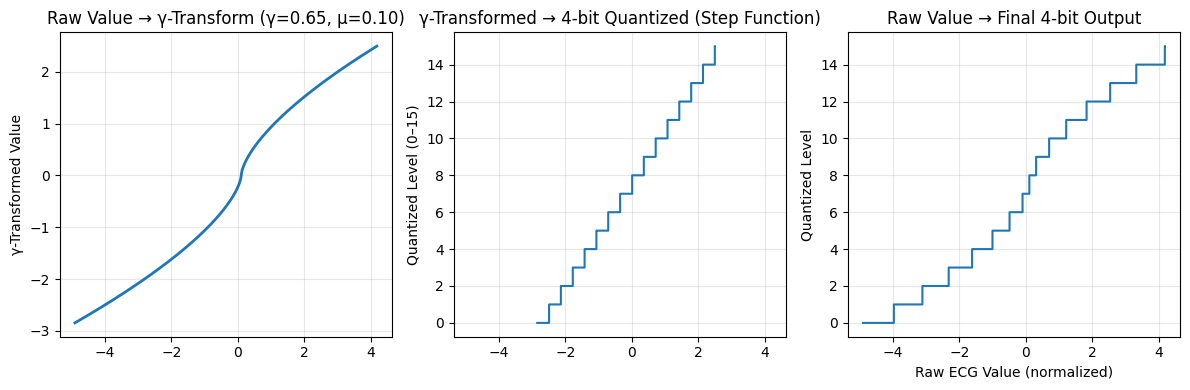

In [29]:

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True)

# Create a sorted value range covering the ECG input distribution
x_vals = np.linspace(X_norm.min(), X_norm.max(), 2000)

# Stage 1: γ-transform
x_gamma = np.sign(x_vals - mu) * np.abs(x_vals - mu)**gamma

# Normalize gamma-transformed values for quantization
x_min, x_max = x_gamma.min(), x_gamma.max()
x_scaled = (x_gamma - x_min) / (x_max - x_min)

# Stage 2: 4-bit quantization (step function)
N = 4
x_bins = np.floor(x_scaled * (2**N - 1))

# Subplot 1: Raw → γ-transform
axs[0].plot(x_vals, x_gamma, linewidth=2)
axs[0].set_ylabel("γ-Transformed Value")
axs[0].set_title(f"Raw Value → γ-Transform (γ={gamma:.2f}, μ={mu:.2f})")
axs[0].grid(True, alpha=0.3)

# Subplot 2: γ-transform → Quantized (step function)
axs[1].step(x_gamma, x_bins, where="mid")
axs[1].set_ylabel("Quantized Level (0–15)")
axs[1].set_title("γ-Transformed → 4-bit Quantized (Step Function)")
axs[1].grid(True, alpha=0.3)

# Subplot 3: Raw → Final Quantized
axs[2].step(x_vals, x_bins, where="mid")
axs[2].set_xlabel("Raw ECG Value (normalized)")
axs[2].set_ylabel("Quantized Level")
axs[2].set_title("Raw Value → Final 4-bit Output")
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

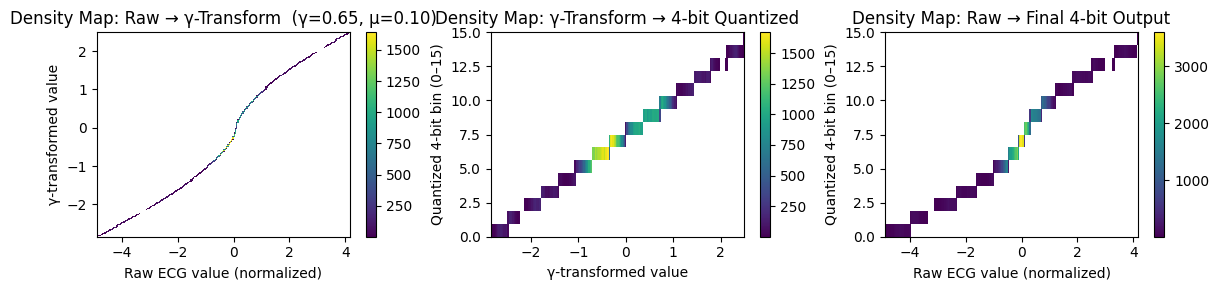

In [32]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12,3))

# Common settings for all density maps, suppress empty bins for cleaner visualization
density_kwargs = dict( bins=200, cmap="viridis", cmin=1 )

# Density 1: Raw → γ-transform
h1 = axs[0].hist2d(
    X_norm,
    X_trans,
    **density_kwargs
)
axs[0].set_xlabel("Raw ECG value (normalized)")
axs[0].set_ylabel("γ-transformed value")
axs[0].set_title(f"Density Map: Raw → γ-Transform  (γ={gamma:.2f}, μ={mu:.2f})")
fig.colorbar(h1[3], ax=axs[0])

# Density 2: γ-transform → Quantized
h2 = axs[1].hist2d(
    X_trans,
    X_q,
    bins=[200, 16],   # fine bins horizontally, 16 levels vertically
    cmap="viridis",
    cmin=1
)
axs[1].set_xlabel("γ-transformed value")
axs[1].set_ylabel("Quantized 4-bit bin (0–15)")
axs[1].set_title("Density Map: γ-Transform → 4-bit Quantized")
fig.colorbar(h2[3], ax=axs[1])

# Density 3: Raw → Quantized
h3 = axs[2].hist2d(
    X_norm,
    X_q,
    bins=[200, 16],
    cmap="viridis",
    cmin=1
)
axs[2].set_xlabel("Raw ECG value (normalized)")
axs[2].set_ylabel("Quantized 4-bit bin (0–15)")
axs[2].set_title("Density Map: Raw → Final 4-bit Output")
fig.colorbar(h3[3], ax=axs[2])

plt.tight_layout()
plt.show()